In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random


In [2]:
print("hello world")

hello world


In [3]:
# Create a directed graph
G = nx.DiGraph()

# Add edges with weights (inferred from image)
edges = [
    ("Attacker", "Pad", {"user": 0.6, "root": 0.6}),
    ("Attacker", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Attacker", "Host 1", {"user": 0.6, "root": 0.48}),

    ("Pad", "Host 1", {"user": 0.6, "root": 0.48}),
    ("Pad", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Pad", "Host 3", {"user": 0.32, "root": 0.32}),
    ("Pad", "Web Server", {"user": 0.8, "root": 0.6}),

    ("Host 1", "Pad", {"user": 0.6, "root": 0.6}),
    ("Host 1", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Host 1", "Host 3", {"user": 0.32, "root": 0.32}),

    ("Host 2", "Host 3", {"user": 0.8, "root": 0.8}),
    ("Host 2", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 2", "Data Server", {"user": 0.8, "root": 0.6}),

    ("Host 3", "Host 2", {"user": 0.8, "root": 0.8}),
    ("Host 3", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 3", "Data Server", {"user": 0.8, "root": 0.6}),

    ("Web Server", "File Server", {"user": 0.8, "root": 0.04}),
    ("Web Server", "Data Server", {"user": 0.8, "root": 0.04}),

    ("File Server", "Data Server", {"user": 0.8, "root": 0.04})
]

# Add edges to the graph
G.add_edges_from(edges)

# Print nodes and edges
print("Nodes:", G.nodes())
print("Edges:")
for u, v, attr in G.edges(data=True):
    print(f"{u} -> {v}, weights: user={attr['user']}, root={attr['root']}")


Nodes: ['Attacker', 'Pad', 'Web Server', 'Host 1', 'Host 2', 'Host 3', 'File Server', 'Data Server']
Edges:
Attacker -> Pad, weights: user=0.6, root=0.6
Attacker -> Web Server, weights: user=0.8, root=0.6
Attacker -> Host 1, weights: user=0.6, root=0.48
Pad -> Host 1, weights: user=0.6, root=0.48
Pad -> Host 2, weights: user=0.32, root=0.32
Pad -> Host 3, weights: user=0.32, root=0.32
Pad -> Web Server, weights: user=0.8, root=0.6
Web Server -> File Server, weights: user=0.8, root=0.04
Web Server -> Data Server, weights: user=0.8, root=0.04
Host 1 -> Pad, weights: user=0.6, root=0.6
Host 1 -> Web Server, weights: user=0.8, root=0.6
Host 1 -> Host 2, weights: user=0.32, root=0.32
Host 1 -> Host 3, weights: user=0.32, root=0.32
Host 2 -> Host 3, weights: user=0.8, root=0.8
Host 2 -> File Server, weights: user=0.8, root=0.6
Host 2 -> Data Server, weights: user=0.8, root=0.6
Host 3 -> Host 2, weights: user=0.8, root=0.8
Host 3 -> File Server, weights: user=0.8, root=0.6
Host 3 -> Data Serv

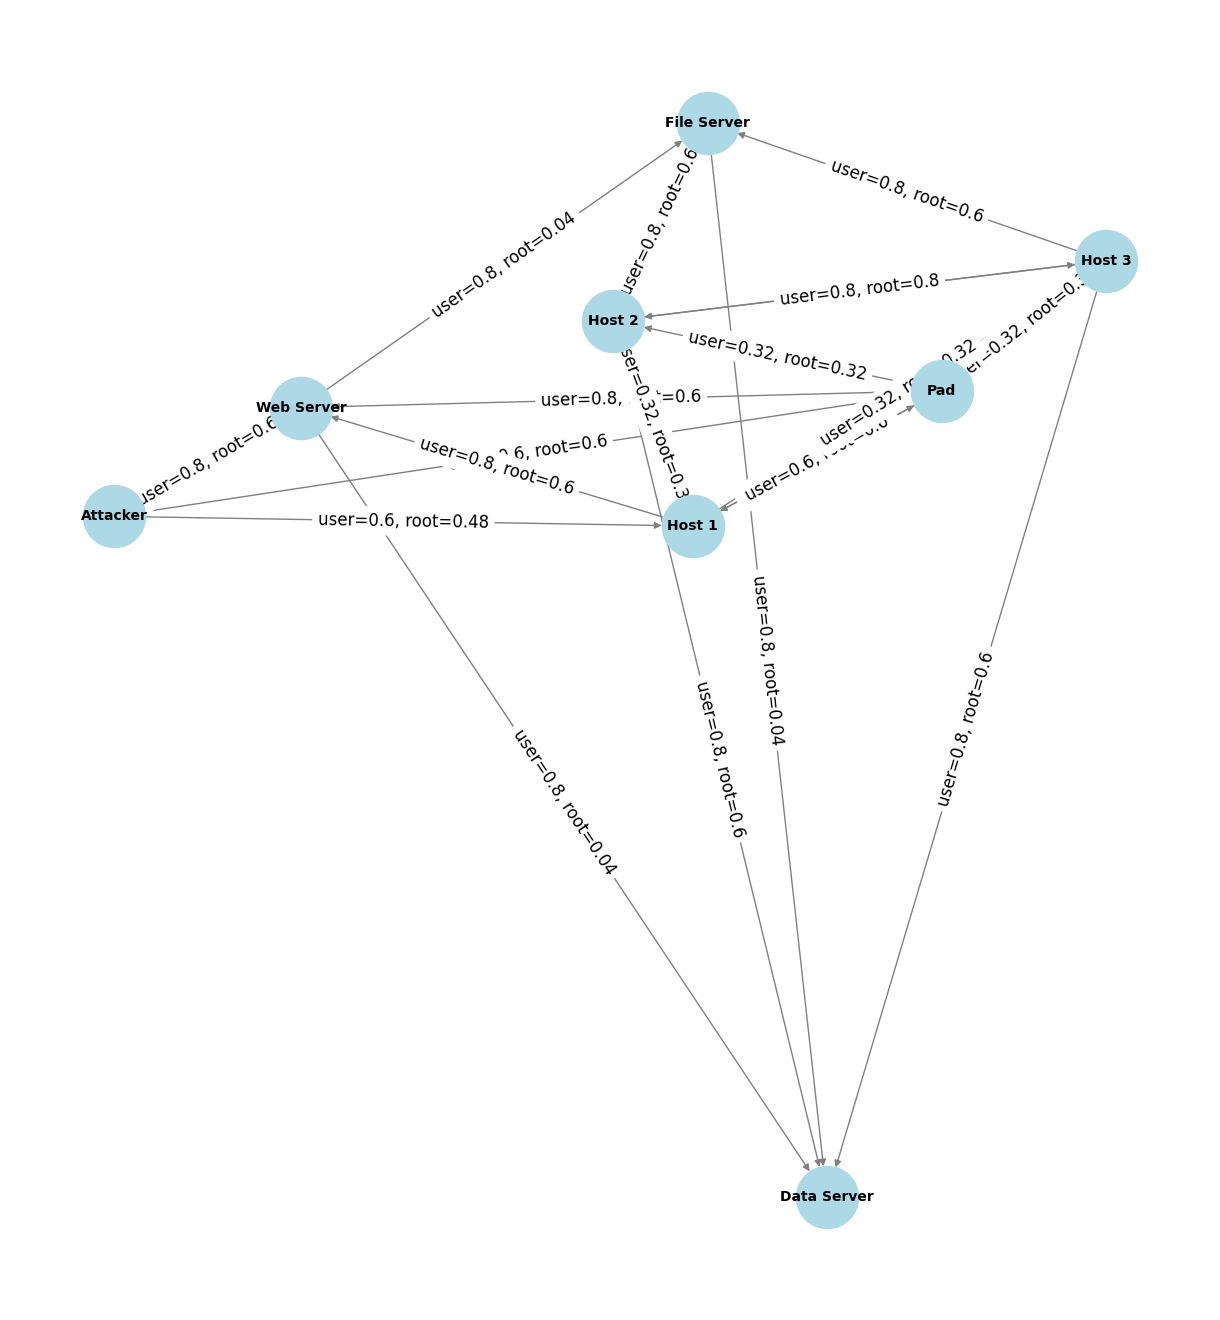

In [4]:

# Draw the graph
plt.figure(figsize=(12, 13))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=10, font_weight='bold')

# Draw edge labels with weights
edge_labels = {(u, v): f"user={d['user']}, root={d['root']}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

plt.show()

In [5]:
def greedy_path_max(graph, start, goal):
    # Build a list of network nodes excluding the attacker
    node_list = [node for node in graph.nodes() if node != start]
    visited_vector = [0] * len(node_list)

    path = [start]
    current = start

    while current != goal:
        neighbors = list(graph.successors(current))
        if not neighbors:
            print("No path to goal found.")
            return path, visited_vector

        # Choose the neighbor with the highest max(user, root)
        next_node = max(
            neighbors,
            key=lambda n: max(graph[current][n]['user'], graph[current][n]['root'])
        )
        current = next_node
        path.append(current)

        # Mark as visited only if it's not the attacker
        if current != start:
            idx = node_list.index(current)
            if visited_vector[idx] == 1:
                print("Cycle detected. Breaking.")
                break
            visited_vector[idx] = 1

    return path, visited_vector, node_list

# Run it
path, visit_vector, tracked_nodes = greedy_path_max(G, "Attacker", "Data Server")

# Print results
print("Greedy path using max(user, root):")
print(" -> ".join(path))

print("\nVisited node vector:")
for node, visited in zip(tracked_nodes, visit_vector):
    print(f"{node}: {visited}")

Greedy path using max(user, root):
Attacker -> Web Server -> File Server -> Data Server

Visited node vector:
Pad: 0
Web Server: 1
Host 1: 0
Host 2: 0
Host 3: 0
File Server: 1
Data Server: 1


In [8]:
# Chuyển đổi tên đỉnh thành chỉ số
node_to_idx = {node: idx for idx, node in enumerate(G.nodes())}
idx_to_node = {idx: node for node, idx in node_to_idx.items()}
num_nodes = len(G.nodes())

# Thông số Q-learning
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Epsilon-greedy (ít ngẫu nhiên để gần với greedy)
num_episodes = 2000

# Khởi tạo bảng Q
Q = np.zeros((num_nodes, num_nodes))

# Hàm lấy hành động khả thi
def get_possible_actions(state_idx):
    node = idx_to_node[state_idx]
    successors = list(G.successors(node))
    return [node_to_idx[n] for n in successors]

# Hàm chọn hành động theo kiểu greedy (max(user, root))
def choose_greedy_action(state_idx):
    possible_actions = get_possible_actions(state_idx)
    if not possible_actions:
        return None
    state_node = idx_to_node[state_idx]
    # Chọn hành động có max(user, root) cao nhất
    next_action = max(
        possible_actions,
        key=lambda n: max(G[state_node][idx_to_node[n]]['user'], G[state_node][idx_to_node[n]]['root'])
    )
    return next_action

# Hàm chọn hành động (kết hợp greedy và epsilon-greedy)
def choose_action(state_idx):
    if random.uniform(0, 1) < epsilon:
        possible_actions = get_possible_actions(state_idx)
        return random.choice(possible_actions) if possible_actions else None
    else:
        return choose_greedy_action(state_idx)

# Hàm tính phần thưởng
def get_reward(state_idx, action_idx):
    state_node = idx_to_node[state_idx]
    action_node = idx_to_node[action_idx]
    attr = G[state_node][action_node]
    return max(attr['user'], attr['root'])  # Phần thưởng dựa trên max(user, root)

# Huấn luyện Q-learning
start_node = node_to_idx['Attacker']
goal_node = node_to_idx['Data Server']

for episode in range(num_episodes):
    state = start_node
    steps = 0
    while state != goal_node and steps < 50:
        action = choose_action(state)
        if action is None:
            break
        reward = get_reward(state, action)
        next_state = action
        best_next_q = np.max(Q[next_state])
        Q[state][action] += alpha * (reward + gamma * best_next_q - Q[state][action])
        state = next_state
        steps += 1

# Phân tích để tìm 2 vị trí honeypot
def find_two_honeypot_positions():
    incoming_q = np.sum(Q, axis=0)  # Tổng Q-value đến mỗi đỉnh
    top_indices = np.argpartition(incoming_q, -2)[-2:]  # Top 2
    top_indices = top_indices[np.argsort(-incoming_q[top_indices])]  # Sắp xếp giảm dần
    honeypot_nodes = [idx_to_node[idx] for idx in top_indices]
    honeypot_scores = [incoming_q[idx] for idx in top_indices]
    return honeypot_nodes, honeypot_scores

# In kết quả
honeypot_nodes, honeypot_scores = find_two_honeypot_positions()
print("Hai vị trí tối ưu để đặt honeypot:")
for node, score in zip(honeypot_nodes, honeypot_scores):
    print(f"- {node}: Tổng Q-value = {score:.4f}")

# So sánh với đường đi greedy
def greedy_path_max(graph, start, goal):
    node_list = [node for node in graph.nodes() if node != start]
    visited_vector = [0] * len(node_list)
    path = [start]
    current = start
    while current != goal:
        neighbors = list(graph.successors(current))
        if not neighbors:
            print("No path to goal found.")
            return path, visited_vector, node_list
        next_node = max(
            neighbors,
            key=lambda n: max(graph[current][n]['user'], graph[current][n]['root'])
        )
        current = next_node
        path.append(current)
        if current != start:
            idx = node_list.index(current)
            if visited_vector[idx] == 1:
                print("Cycle detected. Breaking.")
                break
            visited_vector[idx] = 1
    return path, visited_vector, node_list

path, visit_vector, tracked_nodes = greedy_path_max(G, "Attacker", "Data Server")
print("\nGreedy path using max(user, root):")
print(" -> ".join(path))

Hai vị trí tối ưu để đặt honeypot:
- Web Server: Tổng Q-value = 6.4986
- Host 2: Tổng Q-value = 3.6846

Greedy path using max(user, root):
Attacker -> Web Server -> File Server -> Data Server
